# 3-Machine Learning with the Preferential Balloting Random Forest
In this notebook, I create and run the Random Forest setup of my own design, the Preferential Balloting Random Forest. By running many decorrelated Decision Tree Classifiers on my Awards Season data set (see [scraping](https://github.com/njparker1993/oscars_predictions/blob/master/scraping.ipynb) and [table_assemblage](https://github.com/njparker1993/oscars_predictions/blob/master/table_assembling.ipynb) notebooks for the feature creation). Using this strategy I simulate the Oscars with a voting body of around 7,000 members.

In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# Setting Up our DataFrame
First, we load in the ML ready data frame from the table_assemling notebook

In [6]:
full_table = pd.read_csv('./data/processed_results/osc_df')

In [7]:
min_year = 1995 # This is the first year that all awards shows have occured
# Training Set - Excluding 2019
train = full_table.loc[((full_table['year'] < 2022) & (full_table['year'] > min_year))]
test_2022 = full_table.loc[(full_table['year'] == 2022)]

print('training set contains:', train.shape[0], 'movies')
print('Prediciting on:', test_2022.shape[0], 'movies')

training set contains: 181 movies
Prediciting on: 10 movies


In [16]:
# Identify predictors

full_predictors = ['year','nom_gg_drama', 'winner_gg_drama', 'nom_gg_comedy', 'winner_gg_comedy',
       'nom_pga', 'winner_pga', 'nom_bafta', 'winner_bafta', 'nom_dga', 'winner_dga',
        'nom_sag', 'winner_sag', 'nom_cannes', 'winner_cannes','nominations']

nominees = ['Everything Everywhere All at Once', 'All uiet on the Western Front', 'Avatar: The Way of Water', 'The Banshees of Inisherin', 'Elvis', 'The Fablemans', 'Tár', 'Top Gun: Maverick', 'Triangle of Sadness', 'Women Talking']

In [9]:
print(list(test_2022.film))

['Everything Everywhere All at Once', 'All Quiet on the Western Front ', 'Avatar: The Way of Water', 'The Banshees of Inisherin', 'Elvis ', 'The Fabelmans', 'Tár', 'Top Gun: Maverick', 'Triangle of Sadness', 'Women Talking ']


# Simulating a Voter using a Decision Tree
Each 'Voter' will take a Decisions Tree trained on a smaller part of the data to pick that voter's rankings of the Best Picture Nominees

In [10]:
# The model I am using to predict per voter is a Decison Tree
voter1 = DecisionTreeClassifier(splitter='random',
                                max_depth=3,# Low depth allows for some randomness
                                min_samples_leaf=3,
                                random_state = 92)

Each DecisionTree in our Preferential Balloting Random Forest needs to produce ranked ballot rather that a classificaiton per film. The difference in the outputs of a tree from a Traditiona Random Forest and a tree from this Preferential Balloting Random Forest can be seen below:

![title](pb_rf_tree.png)

In [1]:
def simulate_a_vote(model, train_df, to_predict_df, full_predictors):
    """
    This function creates, trains, and predicts with a DecisionTree to simulate an Academy voter.
    Each tree only sees a part of the data and gets Noise to decorrelate them from each other.
    The prediction is then ranked to create our ballot for Preferential Balloting
    """
    
    train = train_df.copy()
    test = to_predict_df.copy()
    
    # A noise column, randomly generated each time represents a voter's bias
    #used to decorelate data from each other
    train.loc[:,'Noise'] = np.random.rand(train_df.shape[0])
    test.loc[:,'Noise'] = np.random.rand(to_predict_df.shape[0])

    # Looking at a random amount of awards shows (similar to bootstrapping)
    # This reflects a voter's attention to the season
    # num_features is how many of the features they care about
    num_features = np.random.choice(int(len(full_predictors)/1.7)) #full predictora are nominations and wins in other competitions
    voter_features = list(np.random.choice(full_predictors, num_features)) + ['Noise']

    x = np.array(train[voter_features])
    y = np.array(train['Oscar_win'])
    
    model.fit(x,y)
    
    # Probability of the voter will represent the ranked votes in the ballot_clean array
    ballot_clean = model.predict_proba(np.array(test[voter_features]))[:,1]
    # Add small random values to break up ties
    ballot = ballot_clean + np.random.rand(len(ballot_clean))/10000
    
    # Use np.argsort() to rank the order of the probA
    # The Academy uses ranked votes calculate winner

    temp = ballot.argsort() # indices that will sort ballot in ascending order
    ranks = np.empty_like(temp) #this array stores the rank of each ballot probability 
    ranks[temp] = np.arange(len(ballot)) #set values of ranks at the indices specified by temp
    ranks = np.abs(ranks - len(ballot)) #hghest rank corresponds to the smallest probability
    return ranks # ten ranks for each films on the nominated list - if rank[0]=2 first film on the list received the 3 hghest porbability 

vote = simulate_a_vote(voter1, train, test_2022, full_predictors)
print("This voter's ballot looks like:",vote)
position = np.argmin(vote)
print(f"This means their first choice is the {position + 1}th film in our df: {nominees[position]}")

# Simulating the Entire Academy
By 'casting a vote' many times, we can get the ballot from the entire academy

In [3]:
# function which returns a given number of ballots an nparray of ballots
def simulate_voting_body(num_voters, model, train_df, to_predict_df, full_predictors):
    """
    Runs simulate_a_vote and collects ballots from an academy of num_voters size
    """
    collected_ballots = np.zeros((num_voters, to_predict_df.shape[0]))
    for i in range(num_voters):
        collected_ballots[i,:] = simulate_a_vote(model, train_df, to_predict_df, full_predictors)
    return collected_ballots

In [11]:
n = 5
print(f'Here is an example of a {n}-person Academy:')
print(simulate_voting_body(n, voter1, train, test_2022, full_predictors))

Here is an example of a 5-person Academy:
[[ 9. 10.  5.  8.  2.  6.  4.  3.  1.  7.]
 [ 1. 10.  9.  2.  7.  5.  4.  3.  8.  6.]
 [10.  3.  4.  1.  5.  2.  8.  7.  6.  9.]
 [ 9.  8.  3.  2.  4.  5.  1.  6.  7. 10.]
 [ 1.  3. 10.  8.  9.  2.  5.  4.  6.  7.]]
<class 'numpy.ndarray'>


In [14]:
def tally_votes(voting_body, list_of_nominees):
    # List of nominees must be in the same order as the vote index
    #firsts is a numpy array where on an index where rank is 1 the value is one, everywhere a value is 0
    firsts = np.where(voting_body==1,1,0)
    tally = np.sum(firsts, axis = 0)
    tallied_votes_df = pd.DataFrame(tally, columns=['Votes']).T
    tallied_votes_df.columns = list_of_nominees
    return tallied_votes_df.T.sort_values('Votes', ascending = False)

Overall, this 1000-person academy's top picks look like this:


<AxesSubplot:>

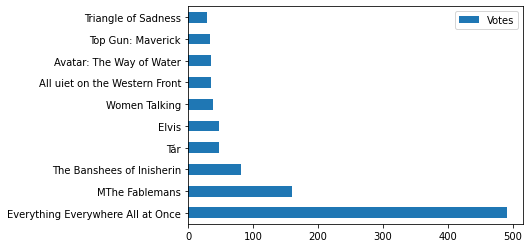

In [15]:
n = 1000
this_academy = simulate_voting_body(n, voter1, train, test_2022, full_predictors)
print(f"Overall, this {n}-person academy's top picks look like this:")
plot_df1 = tally_votes(this_academy, nominees)
plot_df1.plot(kind="barh")

# Tiered Voting Changes
We start elimnating the least voted for film from the ballots and re-ranking the films

In [17]:
def remove_least(voting_body, list_of_nominees):
    """
    A function used for the elimination step of Preferential Balloting
    This function determines which film has the least #1 rankings and removes it
    """
    
    # List of nominees must be in the same order as the vote index
    firsts = np.where(voting_body==1,1,0)
    tally = np.sum(firsts, axis = 0)
    least_votes_index = np.argmin(tally)
    
    # Removes the least voted entry (from # 1 to 0)
    voting_body = np.delete(voting_body, least_votes_index, axis = 1)
    list_of_nominees.remove(list_of_nominees[least_votes_index])
    return voting_body, list_of_nominees

In [35]:
def re_rank_ballots(voting_body):
    """
    Another function used for the elimination step of Preferential Balloting
    Takes a voting body (numpy array)
    Makes sure each row goes from 1 to shape[1]
    """
    re_ranked = np.zeros(voting_body.shape)
    for i in range(voting_body.shape[0]):
        temp = voting_body[i,:].argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(voting_body[i,:]))
        re_ranked[i,:] = ranks + 1
    return re_ranked

In [36]:
def run_one_round_of_eliminations(voting_body, list_of_nominees):
    """
    A function which runs one elimination step of Preferential Balloting 
    Takes in a Voting Body and List of Nominess and returns them,
    but the film with the least #1 votes has bene removed
    """    
    voting_body, list_of_nominees = remove_least(voting_body, list_of_nominees)
    voting_body = re_rank_ballots(voting_body)
    return voting_body, list_of_nominees

In [37]:
new_votes, new_noms = run_one_round_of_eliminations(this_academy, nominees)

print(len(new_noms), 'films remaining')
print('\nNew Standings:')
tally_votes(new_votes, new_noms)

9 films remaining

New Standings:


,Votes
Everything Everywhere All at Once,499
MThe Fablemans,153
The Banshees of Inisherin,83
Top Gun: Maverick,59
Avatar: The Way of Water,48
Elvis,46
Tár,46
Triangle of Sadness,35
Women Talking,31


## Re-Rank until one film has more than 50% of the vote
This is where the real simulation comes in.
We put together all the previous functions to simulate the result of the 2019 Best Picture voting

In [38]:
def run_preferential_voting(voting_body,list_of_nominees, show_steps = False):
    """
    Runs the process of Preferential Balloting on a voting_body(matrix)
    Terminates when one film has greater than 50% of the #1 votes
    """   
    top_pick_percent = tally_votes(voting_body,list_of_nominees).max()[0]/tally_votes(voting_body,list_of_nominees).sum()[0]
    while top_pick_percent < 0.5:
        voting_body,list_of_nominees = run_one_round_of_eliminations(voting_body, list_of_nominees)
        top_pick_percent = tally_votes(voting_body,list_of_nominees).max()[0]/tally_votes(voting_body,list_of_nominees).sum()[0]    
        if show_steps:
            print(tally_votes(voting_body, list_of_nominees),'\n')
    return voting_body, list_of_nominees

# Lets Simulate the Oscars!

In [40]:
min_year = 1995

# Training Set - Excluding 2019
train = full_table.loc[((full_table['year'] < 2022) & (full_table['year'] > min_year))]
test_2022 = full_table.loc[(full_table['year'] == 2022)]

print('training set contains:', train.shape[0], 'movies')
print('Prediciting on:', test_2022.shape[0], 'movies')

# Identify features to predict on
full_predictors = ['year','nom_gg_drama', 'winner_gg_drama', 'nom_gg_comedy', 'winner_gg_comedy',
       'nom_pga', 'winner_pga', 'nom_bafta', 'winner_bafta', 'nom_dga', 'winner_dga',
        'nom_sag', 'winner_sag', 'nom_cannes', 'winner_cannes','nominations']

nominees = ['Everything Everywhere All at Once', 'All uiet on the Western Front', 'Avatar: The Way of Water', 'The Banshees of Inisherin', 'Elvis', 'The Fablemans', 'Tár', 'Top Gun: Maverick', 'Triangle of Sadness', 'Women Talking']
# PicK the model we want for each random voter
voter_model = DecisionTreeClassifier(splitter='random',
                                max_depth=3,
                                min_samples_leaf=3,
                                random_state = 92)

num_voters_academy = 7000
print(f'\nSimulating an Academy with {num_voters_academy} random voters.....')
academy_sim = simulate_voting_body(num_voters=num_voters_academy, model = voter_model, train_df = train, to_predict_df = test_2022, full_predictors=full_predictors)

print('\nInitial Rankings:\n----------------------------------------')
print(tally_votes(academy_sim, nominees),'\n')
print("Now we start eliminating films untill there one has more than 50% of the top picks:\n----------------------------------------")
final_ballot, final_films = run_preferential_voting(academy_sim, nominees, True)

training set contains: 181 movies
Prediciting on: 10 movies

Simulating an Academy with 7000 random voters.....

Initial Rankings:
----------------------------------------
                                   Votes
Everything Everywhere All at Once   3628
MThe Fablemans                       957
The Banshees of Inisherin            468
Tár                                  333
Elvis                                327
Top Gun: Maverick                    320
Avatar: The Way of Water             290
Triangle of Sadness                  249
Women Talking                        227
All uiet on the Western Front        201 

Now we start eliminating films untill there one has more than 50% of the top picks:
----------------------------------------


# And the Oscar goes to...

In [41]:
tally_votes(final_ballot, final_films)

,Votes
Everything Everywhere All at Once,3628
MThe Fablemans,957
The Banshees of Inisherin,468
Tár,333
Elvis,327
Top Gun: Maverick,320
Avatar: The Way of Water,290
Triangle of Sadness,249
Women Talking,227
All uiet on the Western Front,201


In [42]:
bp_winner = np.array(tally_votes(final_ballot, final_films).reset_index())[0][0].split('(')[0].strip()
print(f'And the Oscar goes to...\n🎉🏆{bp_winner}🏆🎉')

And the Oscar goes to...
🎉🏆Everything Everywhere All at Once🏆🎉


This random forest set-up simulated the academy and changed the normally vote counting process of the RF to use preferential balloting. I check the result of this prediciton process against a number of models in the [AutoML Machine Learning Notebook](https://github.com/njparker1993/oscars_predictions/blob/master/machine_learning_auto_ml.ipynb)